Assignment 4: Random Forests and Gradient Boosting
---------------------------
Use all explanatory variables (except neighborhood) and all 506 census tract observations from the Boston Housing Study. Use one of two response variables: (1) the median value of homes in thousands of 1970 dollars or (2) the log median value of homes in thousands of 1970 dollars. Employ at least two regression modeling methods selected from those discussed in Chapter 4 of the Géron (2017) textbook: linear regression, stochastic gradient descent, ridge regression, lasso regression, and elastic net. Also employ random forests to the regression problem, following methods described in Géron (2017) Chapter 7. Evaluate these methods within a cross-validation design, using root mean-squared error (RMSE) as an index of prediction error. Python scikit-learn should be your primary environment for conducting this research.

Try alternative versions of random forests and gradient boosting. Select a best modeling method for the Boston Housing Study. Employ that method on the full data set, obtaining results that you can report to management.

Regarding the management problem, imagine that you again are advising a real estate brokerage firm in its attempt to employ machine learning methods. The firm wants to use machine learning to complement conventional methods for assessing the market value of residential real estate. Of the modeling methods examined in your study, which would you recommend to management and why? Reviewing the results of the random forests and gradient boosting model you have selected to present to management, which explanatory variables are most important in predicting home prices?

Boston house prices dataset
---------------------------
The Boston Housing Study is a market response study of sorts, with the market being 506 census tracts in the Boston metropolitan area. The objective of the study was to examine the effect of air pollution on housing prices, controlling for the effects of other explanatory variables. The response variable is the median price of homes in the census track. 

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per 10,000 (USD)
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in 1000's (USD)

In [22]:
# Import dependencies for analysis/data prep
import numpy as np
import pandas as pd
import os
from math import sqrt  # for root mean-squared error calculation
import itertools
from scipy import stats as st
import random
import time

# Modeling routines from Scikit Learn packages
from sklearn.metrics import mean_squared_error, r2_score    
from sklearn import preprocessing  # feature transformations
from sklearn.compose import ColumnTransformer   # for scaling particular features
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet
from sklearn.svm import LinearSVC
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, cross_val_predict
# import xgboost

# Plotting and visualization
from yellowbrick.model_selection import CVScores, FeatureImportances
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
%matplotlib inline

# Data preparation and initial inspection

In [3]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

In [4]:
# Read in Boston housing data to a pandas DataFrame
boston_input = pd.read_csv('boston.csv')

In [5]:
# Inspect first 5 rows of data
boston_input.head()

,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [6]:
# Drop neighborhood attribute
boston_input = boston_input.drop('neighborhood', 1)

In [7]:
# Check for missing values
boston_input.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rooms      0
age        0
dis        0
rad        0
tax        0
ptratio    0
lstat      0
mv         0
dtype: int64

# Descriptive statistics and visualizations of original data

In [7]:
# Inspect data shape: 506 rows, 13 columns/features/variables/attributes
boston_input.shape

(506, 13)

**Table 1: Initial descriptive statistics on original data**

In [29]:
# Inspect data
boston_input.describe(include='all')

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


**Figure 1: Pair plot of feature relationships**

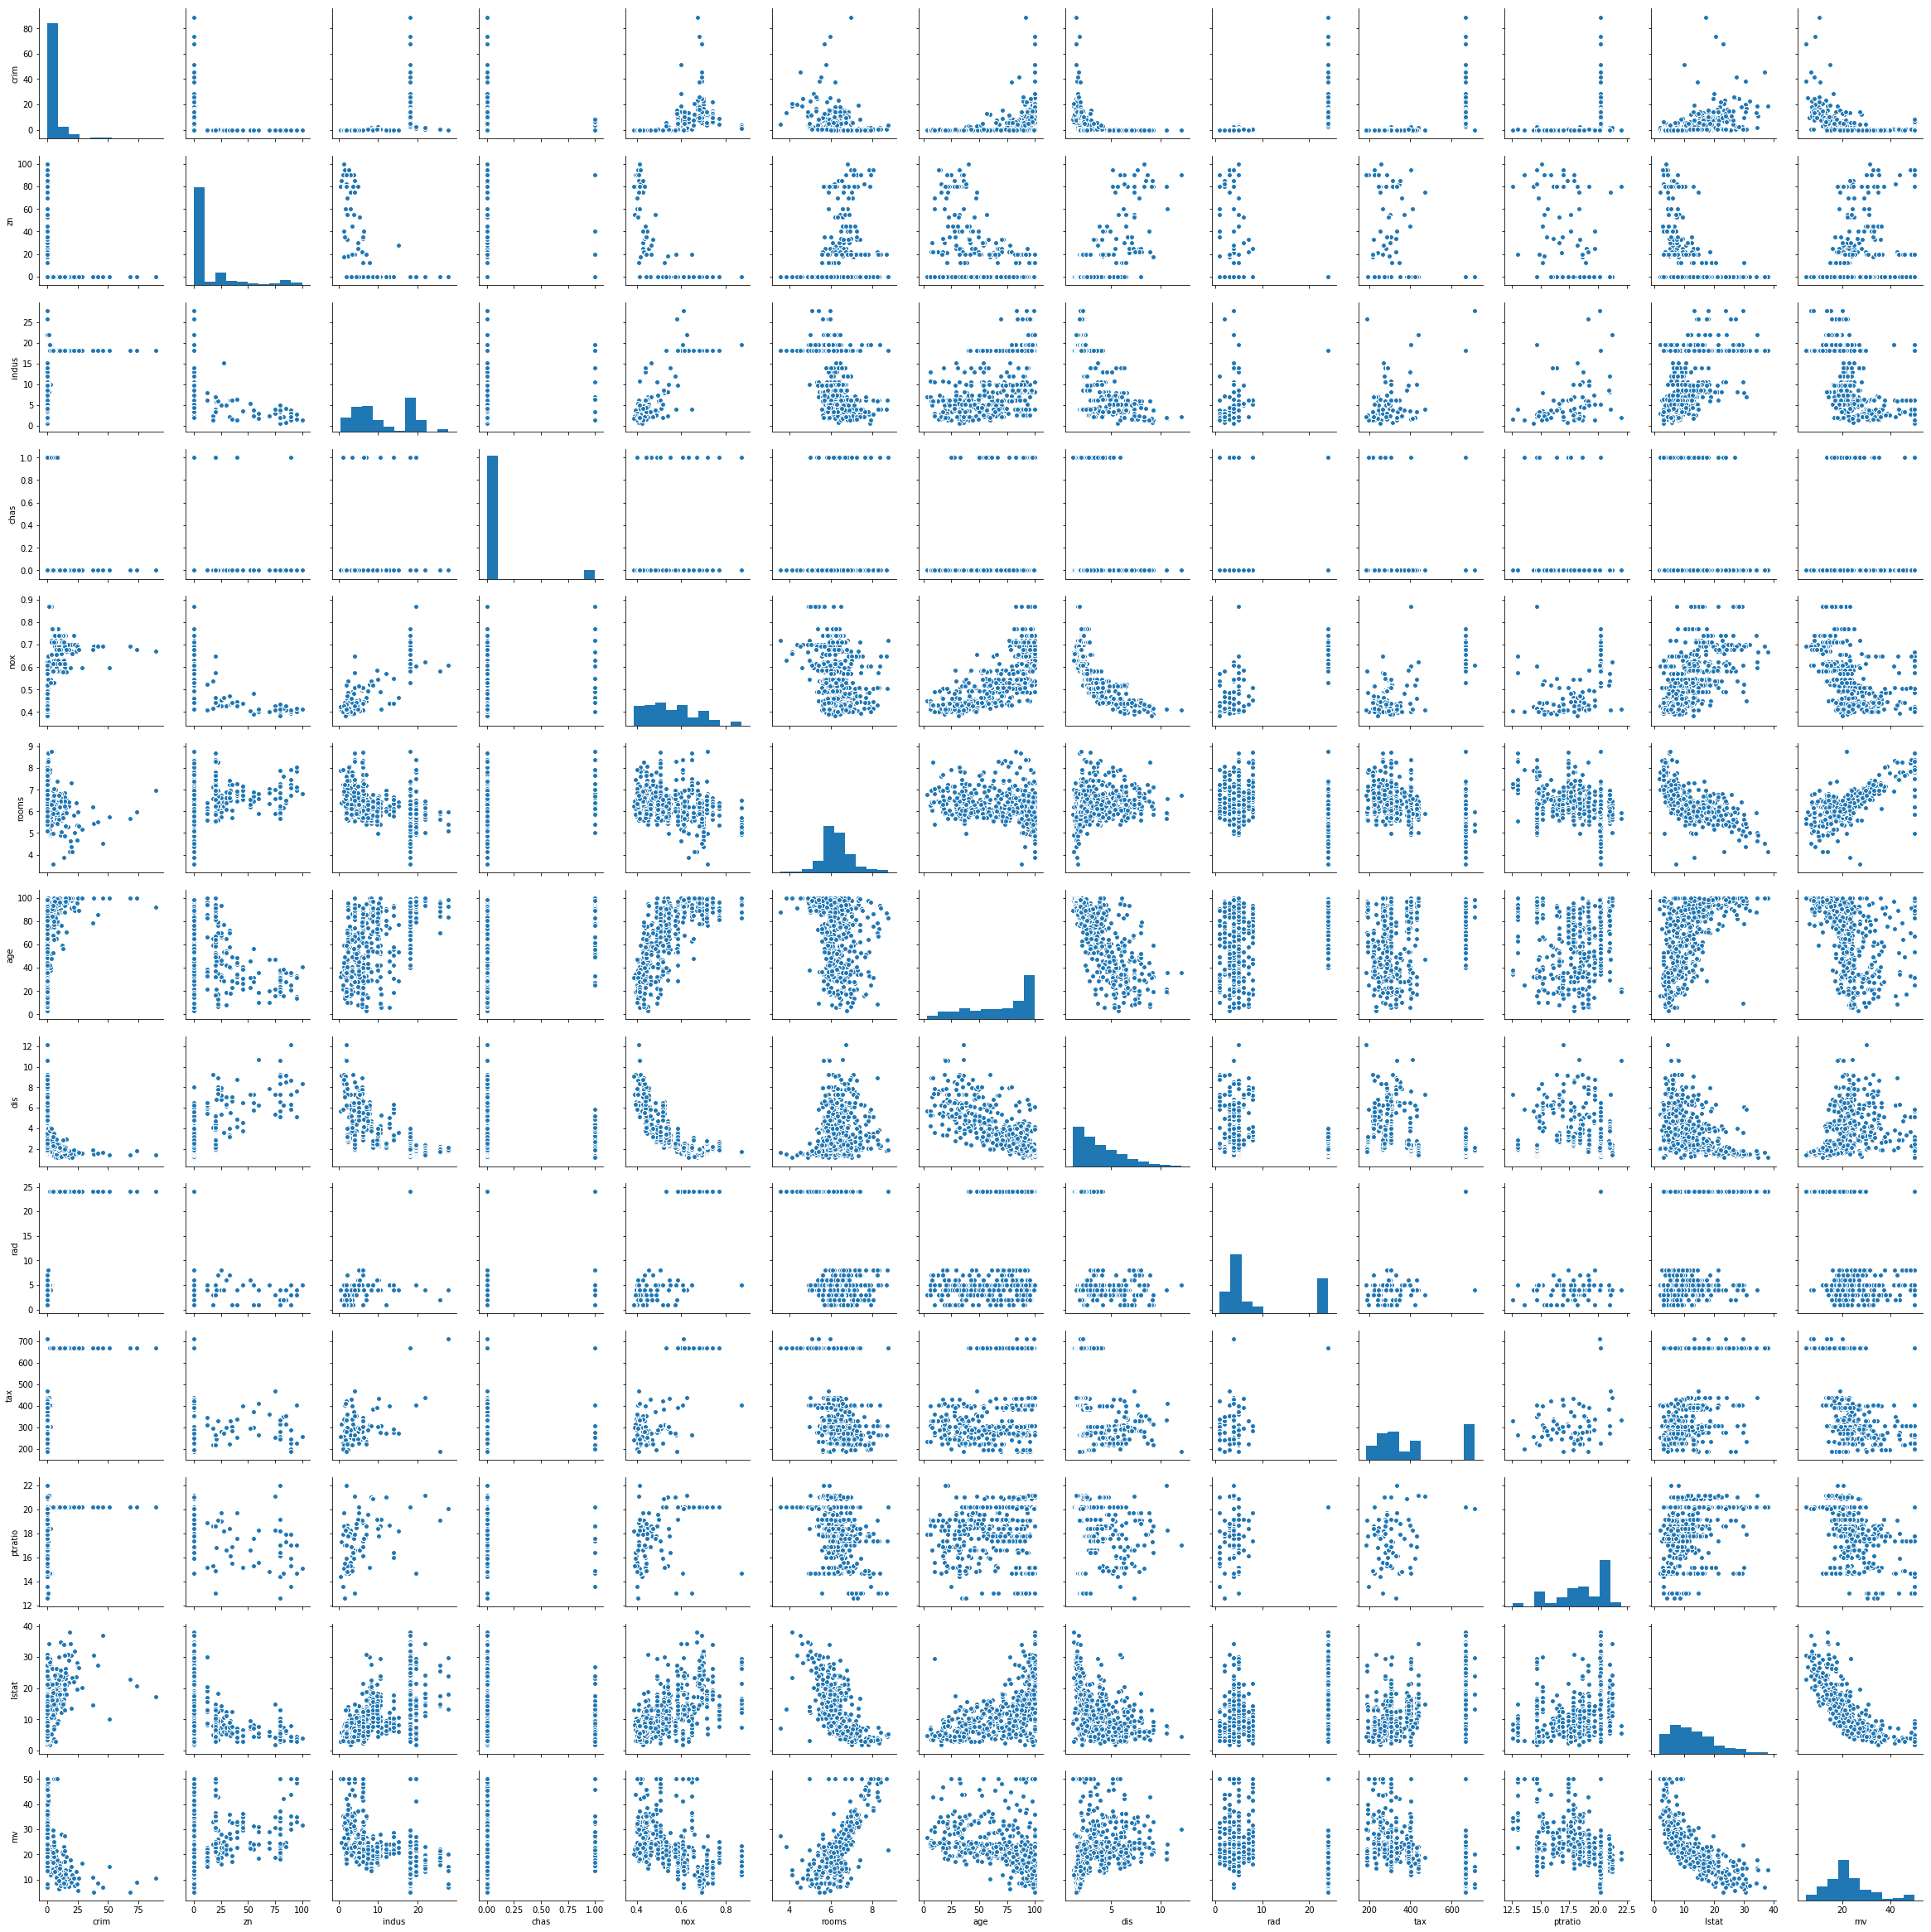

In [12]:
# Create pair plot for initial inspection of relationships
sns.pairplot(boston_input, diag_kind='hist')

# mv increases as the value of rooms increases 
# mv decreases with increase in lstat

**Figure 2: Box plots of original data**

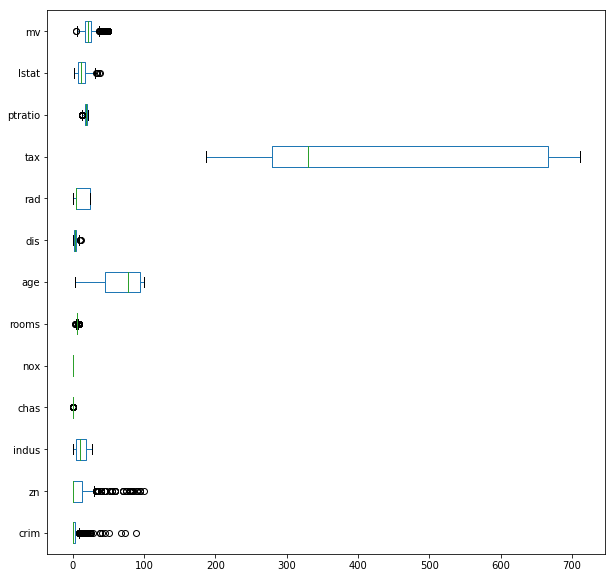

In [7]:
# Create boxplot of raw data to examine values, ranges, and measures of centrality
boston_input.boxplot(vert=False, figsize=(10,10), grid=False)

**Figure 3: Alternate box plots of original data**

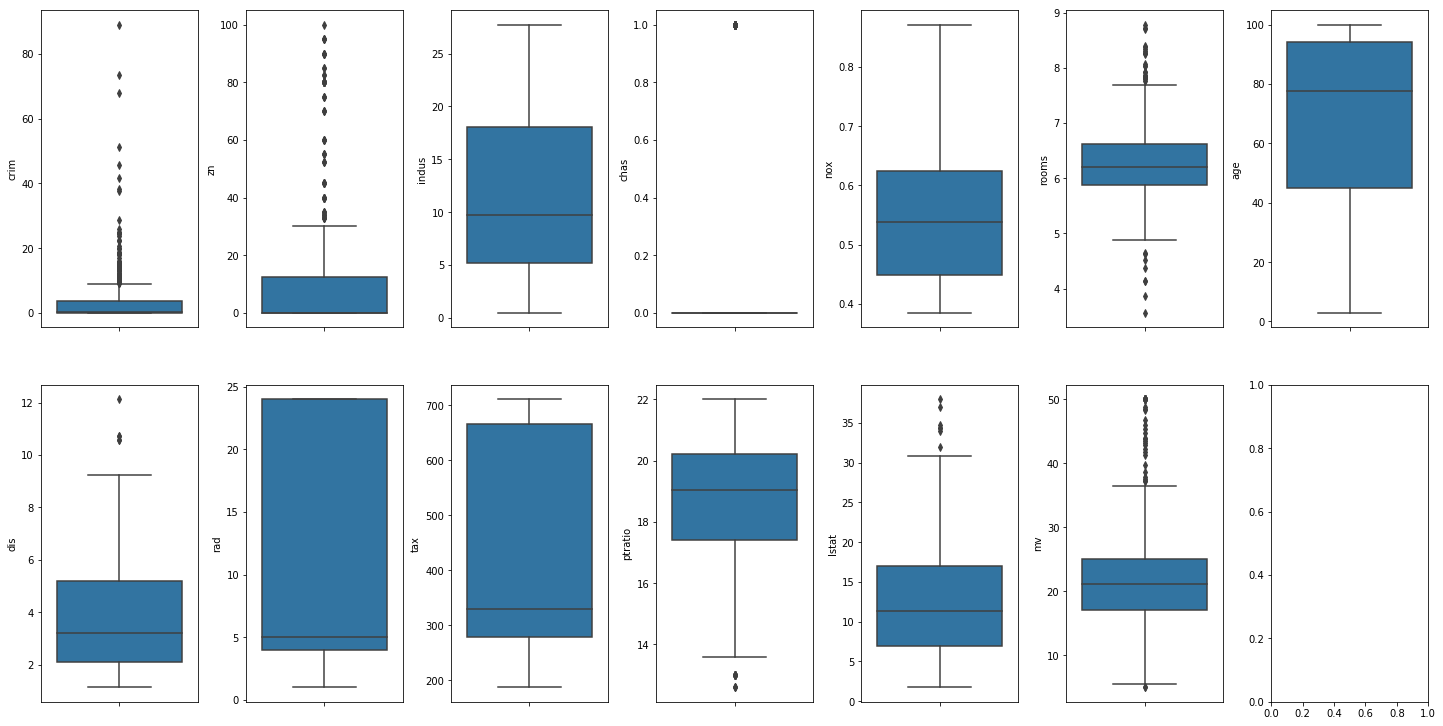

In [9]:
# Alternate look at features with boxplot
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in boston_input.items():
    sns.boxplot(y=k, data=boston_input, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

**Table 2: Outliers**

In [12]:
# Examine outliers for each feature
for k, v in boston_input.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(boston_input)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column crim outliers = 13.04%
Column zn outliers = 13.44%
Column indus outliers = 0.00%
Column chas outliers = 100.00%
Column nox outliers = 0.00%
Column rooms outliers = 5.93%
Column age outliers = 0.00%
Column dis outliers = 0.99%
Column rad outliers = 0.00%
Column tax outliers = 0.00%
Column ptratio outliers = 2.96%
Column lstat outliers = 1.38%
Column mv outliers = 7.71%


**Figure 4: Distributions of features**

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: T

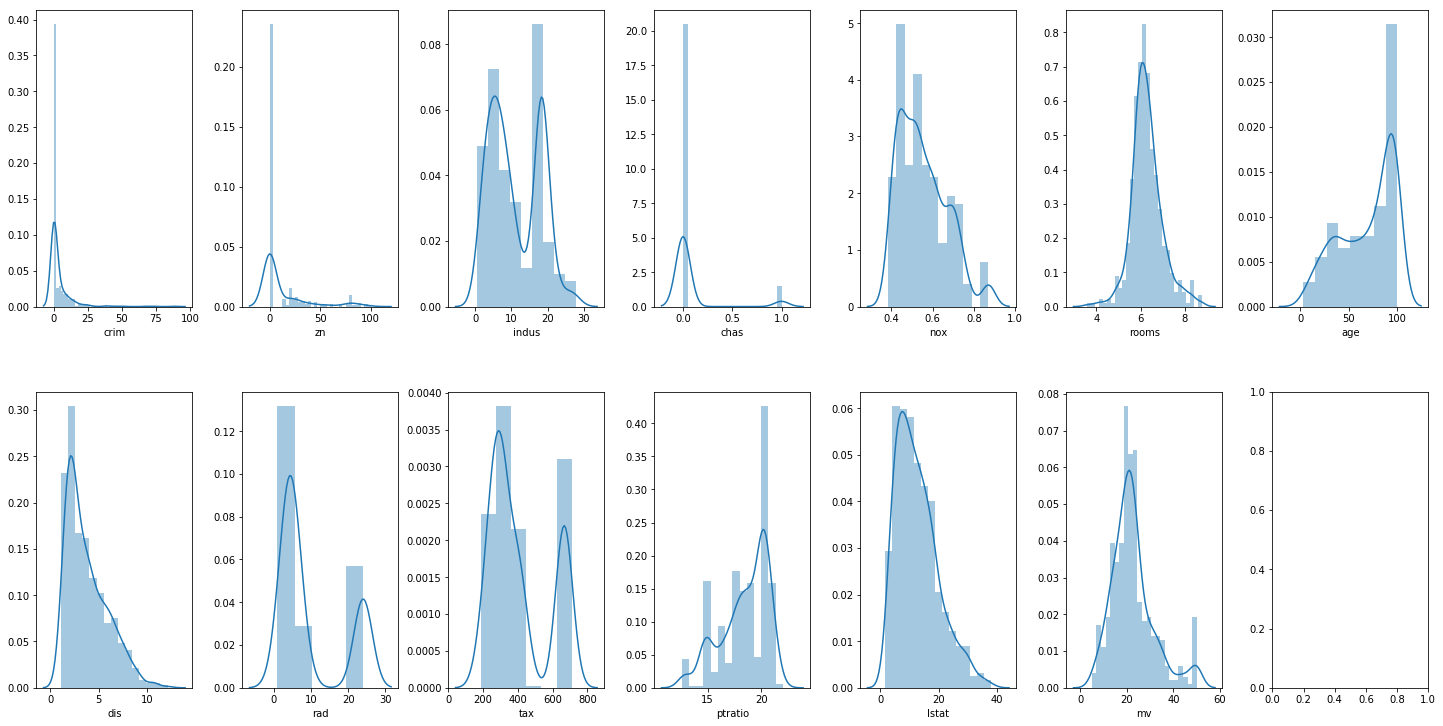

In [13]:
# Examine shape of distributions of features
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in boston_input.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

# The histogram also shows that columns CRIM, ZN, B has highly skewed distributions. 
# Also MEDV looks to have a normal distribution (the predictions) and other colums seem to have 
# normal or bimodel ditribution of data except CHAS (which is a discrete variable).

**Figure 5: Distribution of median sale price (mv)**

<function matplotlib.pyplot.show(*args, **kw)>

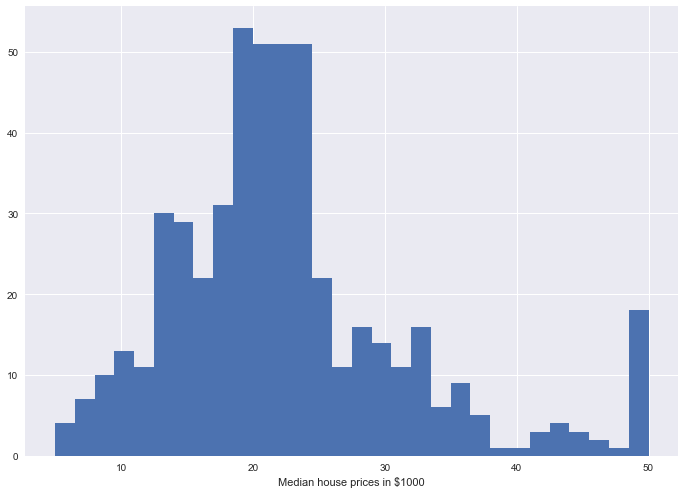

In [17]:
# Examine target variable (mv) specifically
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(boston_input['mv'], bins=30)
plt.xlabel("Median house prices in $1000")
plt.show

# Prices are distributed mostly normally, with a few outliers on the higher end
# Most houses are around the 20-24k range

**Figure 6: Correlation matrix for original data**

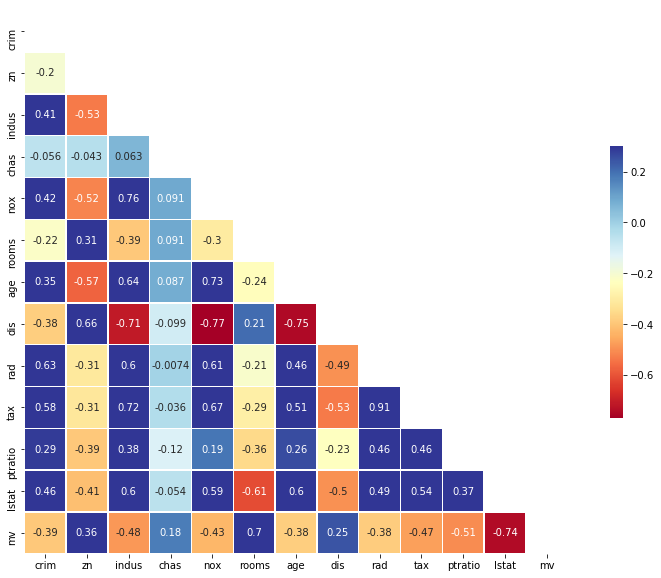

In [81]:
# Create correlation matrix for original data
plt.figure(figsize=(15,10))
corr = boston_input.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, vmax=.3, cmap="RdYlBu", square=True, linewidths = .5, 
            cbar_kws={"shrink": .5})

# rm (average # of rooms per dwelling) has a strong positive correlation with mv (price) 
# lstat (% lower status of the population) has a strong negative correlation with mv

# Examine multicolinearity, where features have a strong correlation
# rad (index of accessibility to radial highways) and tax (full-value property-tax rate per $10000) 
# highly correlated
# dis (weighted distances to 5 Boston employment centers) and age (proportion of owner-occupied units built
# prior to 1940) highly correlated

# From correlation matrix, we see TAX and RAD are highly correlated features. 
# The columns LSTAT, INDUS, RM, TAX, NOX, PTRATIO has a correlation score above 0.5 with mv 
# which is a good indication of using as predictors. 


# Data transformation - log transformation of median value

In [7]:
# Log transform mv values
boston_log_mv = boston_input.copy()
boston_log_mv['mv'] = boston_input['mv'].apply(np.log)

In [8]:
# Inspect first 5 rows
boston_log_mv.head()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,3.178054
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,3.072693
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,3.546740
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,3.508556
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,3.589059


**Figure 7: MV versus MV log**

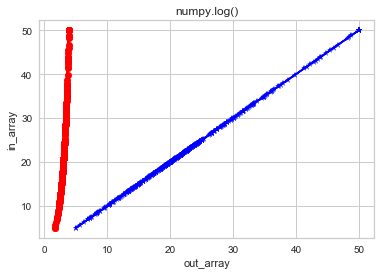

In [11]:
# Create plot for visual comparison
plt.plot(boston_input['mv'], boston_input['mv'],  
         color = 'blue', marker = "*") 
  
# Red for log transformed md, blue for original mv values
plt.plot(boston_log_mv['mv'], boston_input['mv'],  
         color = 'red', marker = "o") 

plt.title("numpy.log()") 
plt.xlabel("out_array") 
plt.ylabel("in_array") 
plt.show()

In [9]:
# Data prep
# Prepare transformed data and inspect 
cols_scaled = boston_log_mv.columns.tolist()
cols_scaled = cols_scaled[-1:] + cols_scaled[:-1]
boston_log_mv_model = boston_log_mv[cols_scaled]

# Inspect scaled data
boston_log_mv_model.describe(include='all')

,mv,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.034558,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063
std,0.408275,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062
min,1.609438,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000
25%,2.834680,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000
50%,3.054001,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000
75%,3.218876,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000
max,3.912023,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000


# Data transformation - standard scaler

In [16]:
# Create copy of the original DataFrame
boston_scaled_standard = boston_log_mv.copy()

# Scaling
col_names = ['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'mv']
features = boston_scaled_standard[col_names]
scaler = preprocessing.StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Assign result to columns
boston_scaled_standard[col_names] = features
print(boston_scaled_standard)

         crim        zn     indus      chas       nox     rooms       age  \
0   -0.419782  0.284830 -1.287909 -0.272599 -0.144217  0.413672 -0.120013   
1   -0.417339 -0.487722 -0.593381 -0.272599 -0.740262  0.194274  0.367166   
2   -0.417342 -0.487722 -0.593381 -0.272599 -0.740262  1.282714 -0.265812   
3   -0.416750 -0.487722 -1.306878 -0.272599 -0.835284  1.016303 -0.809889   
4   -0.412482 -0.487722 -1.306878 -0.272599 -0.835284  1.228577 -0.511180   
..        ...       ...       ...       ...       ...       ...       ...   
501 -0.413229 -0.487722  0.115738 -0.272599  0.158124  0.439316  0.018673   
502 -0.415249 -0.487722  0.115738 -0.272599  0.158124 -0.234548  0.288933   
503 -0.413447 -0.487722  0.115738 -0.272599  0.158124  0.984960  0.797449   
504 -0.407764 -0.487722  0.115738 -0.272599  0.158124  0.725672  0.736996   
505 -0.415000 -0.487722  0.115738 -0.272599  0.158124 -0.362767  0.434732   

          dis       rad       tax   ptratio     lstat        mv  
0    0.14

**Figure 8: Correlation matrix for standard scaled data**

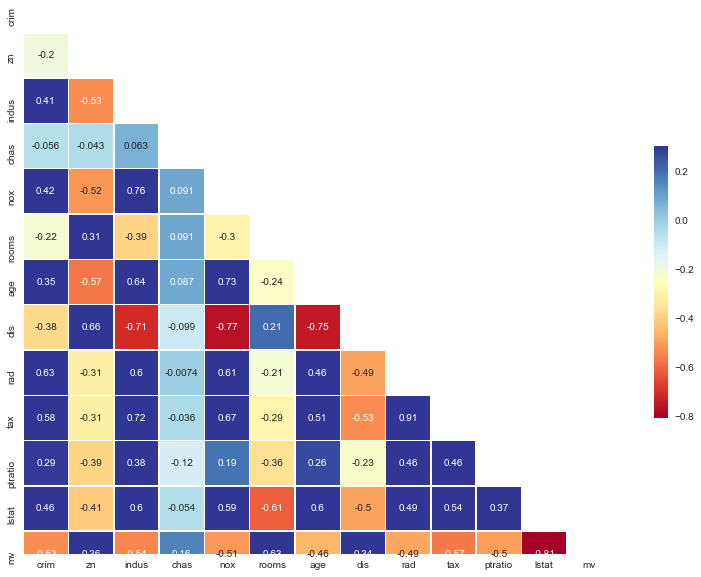

In [17]:
# Create correlation matrix for scaled data for comparison
plt.figure(figsize=(15,10))
corr = boston_scaled_standard.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, vmax=.3, cmap="RdYlBu", square=True, linewidths = .5, 
            cbar_kws={"shrink": .5})

In [18]:
# Data prep
# Prepare scaled data and inspect 
cols_scaled = boston_scaled_standard.columns.tolist()
cols_scaled = cols_scaled[-1:] + cols_scaled[:-1]
boston_scaled_standard_model = boston_scaled_standard[cols_scaled]

# Inspect scaled data
boston_scaled_standard_model.describe(include='all')

,mv,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,506.000000,5.060000e+02,5.060000e+02
mean,-4.353127e-16,-1.123388e-16,7.898820e-17,2.106352e-16,-3.510587e-17,-2.808469e-16,-4.563763e-17,-1.474446e-16,-8.425408e-17,-1.123388e-16,0.000000,-4.212704e-16,-3.089316e-16
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990,1.000990e+00,1.000990e+00
min,-3.494045e+00,-4.197819e-01,-4.877224e-01,-1.557842e+00,-2.725986e-01,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-9.828429e-01,-1.313990,-2.707379e+00,-1.531127e+00
25%,-4.900528e-01,-4.109696e-01,-4.877224e-01,-8.676906e-01,-2.725986e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-6.379618e-01,-0.767576,-4.880391e-01,-7.994200e-01
50%,4.766992e-02,-3.906665e-01,-4.877224e-01,-2.110985e-01,-2.725986e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-5.230014e-01,-0.464673,2.748590e-01,-1.812536e-01
75%,4.519022e-01,7.396560e-03,4.877224e-02,1.015999e+00,-2.725986e-01,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.661245e+00,1.530926,8.065758e-01,6.030188e-01
max,2.151329e+00,9.933931e+00,3.804234e+00,2.422565e+00,3.668398e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.661245e+00,1.798194,1.638828e+00,3.548771e+00


# Data transformation - Min-Max scaler

In [21]:
# Create copy of the original DataFrame
boston_scaled_minmax = boston_log_mv.copy()

# Scaling
col_names = ['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'mv']
features = boston_scaled_minmax[col_names]
scaler = preprocessing.MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

# Assign result to columns
boston_scaled_minmax[col_names] = features
print(boston_scaled_minmax)

         crim    zn     indus  chas       nox     rooms       age       dis  \
0    0.000000  0.18  0.067815   0.0  0.314815  0.577505  0.641607  0.269203   
1    0.000236  0.00  0.242302   0.0  0.172840  0.547998  0.782698  0.348962   
2    0.000236  0.00  0.242302   0.0  0.172840  0.694386  0.599382  0.348962   
3    0.000293  0.00  0.063050   0.0  0.150206  0.658555  0.441813  0.448545   
4    0.000705  0.00  0.063050   0.0  0.150206  0.687105  0.528321  0.448545   
..        ...   ...       ...   ...       ...       ...       ...       ...   
501  0.000633  0.00  0.420455   0.0  0.386831  0.580954  0.681771  0.122671   
502  0.000438  0.00  0.420455   0.0  0.386831  0.490324  0.760041  0.105293   
503  0.000612  0.00  0.420455   0.0  0.386831  0.654340  0.907312  0.094381   
504  0.001161  0.00  0.420455   0.0  0.386831  0.619467  0.889804  0.114514   
505  0.000462  0.00  0.420455   0.0  0.386831  0.473079  0.802266  0.125072   

          rad       tax   ptratio     lstat        

**Figure 9: Correlation matrix for min-max scaled data**

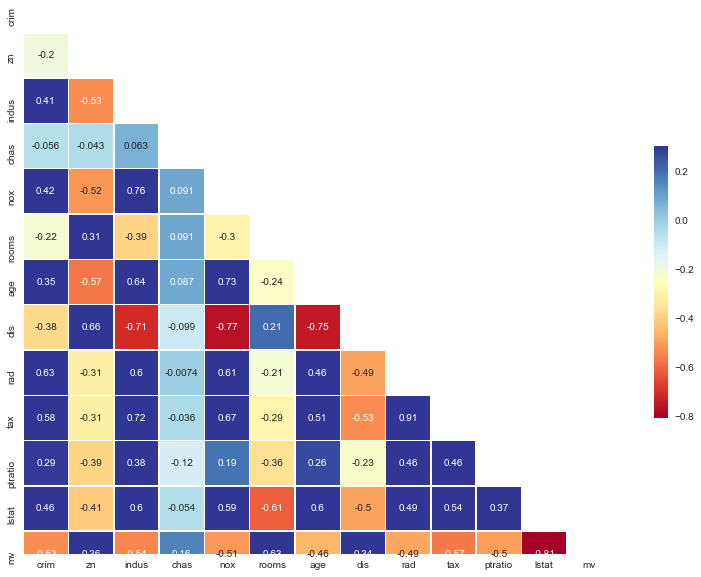

In [22]:
# Create correlation matrix for scaled data for comparison
plt.figure(figsize=(15,10))
corr = boston_scaled_minmax.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, vmax=.3, cmap="RdYlBu", square=True, linewidths = .5, 
            cbar_kws={"shrink": .5})

In [23]:
# Data prep
# Prepare scaled data and inspect 
cols_scaled = boston_scaled_minmax.columns.tolist()
cols_scaled = cols_scaled[-1:] + cols_scaled[:-1]
boston_scaled_minmax_model = boston_scaled_minmax[cols_scaled]

# Inspect scaled data
boston_scaled_minmax_model.describe(include='all')

,mv,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.618922,0.040544,0.113636,0.391378,0.069170,0.349167,0.521869,0.676364,0.242381,0.371713,0.422208,0.622929,0.301409
std,0.177311,0.096679,0.233225,0.251479,0.253994,0.238431,0.134627,0.289896,0.191482,0.378576,0.321636,0.230313,0.197049
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.532116,0.000851,0.000000,0.173387,0.000000,0.131687,0.445392,0.433831,0.088259,0.130435,0.175573,0.510638,0.144040
50%,0.627366,0.002812,0.000000,0.338343,0.000000,0.314815,0.507281,0.768280,0.188949,0.173913,0.272901,0.686170,0.265728
75%,0.698970,0.041258,0.125000,0.646628,0.000000,0.491770,0.586798,0.938980,0.369088,1.000000,0.914122,0.808511,0.420116
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data transformation - Box Cox transformation

In [8]:
# Data transformations and inspection

# Apply transformation
boston_input2 = boston_input.apply(lambda x: x+.01)

# Inspect first 5 rows of transformed dataset
boston_input2.head()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,0.01632,18.01,2.32,0.01,0.548,6.585,65.21,4.1000,1.01,296.01,15.31,4.99,24.01
1,0.03731,0.01,7.08,0.01,0.479,6.431,78.91,4.9771,2.01,242.01,17.81,9.15,21.61
2,0.03729,0.01,7.08,0.01,0.479,7.195,61.11,4.9771,2.01,242.01,17.81,4.04,34.71
3,0.04237,0.01,2.19,0.01,0.468,7.008,45.81,6.0722,3.01,222.01,18.71,2.95,33.41
4,0.07905,0.01,2.19,0.01,0.468,7.157,54.21,6.0722,3.01,222.01,18.71,5.34,36.21


**Figure 10: Pair plot of Box Cox transformed features**

In [9]:
# Box Cox transformation
boston_input3 = boston_input2.apply(lambda x: st.boxcox(x)[0])

# Inspect first 5 rows of transformed dataset
boston_input3.head()

# Visualize relationships again with pair plots
# sns.pairplot(boston_input3, diag_kind='hist')

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,-5.752617,1.708418,1.014663,-587728.314092,-0.810467,2.960401,201.842701,1.264160,0.009943,1.807153,33009.396839,1.939868,4.589092
1,-4.286098,-13.373080,3.075151,-587728.314092,-1.064124,2.905657,260.910666,1.416765,0.664175,1.796475,63758.135934,2.876120,4.380581
2,-4.286990,-13.373080,3.075151,-587728.314092,-1.064124,3.170577,184.938977,1.416765,0.664175,1.796475,63758.135934,1.642857,5.357762
3,-4.076712,-13.373080,0.932774,-587728.314092,-1.111280,3.107229,125.396307,1.568513,1.018925,1.791545,79016.524332,1.226204,5.275244
4,-3.107491,-13.373080,0.932774,-587728.314092,-1.111280,3.157778,157.365843,1.568513,1.018925,1.791545,79016.524332,2.038263,5.450026


**Figure 11: Histogram of distributions of Box Cox transformed features**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c19595860>,
      dtype=object)

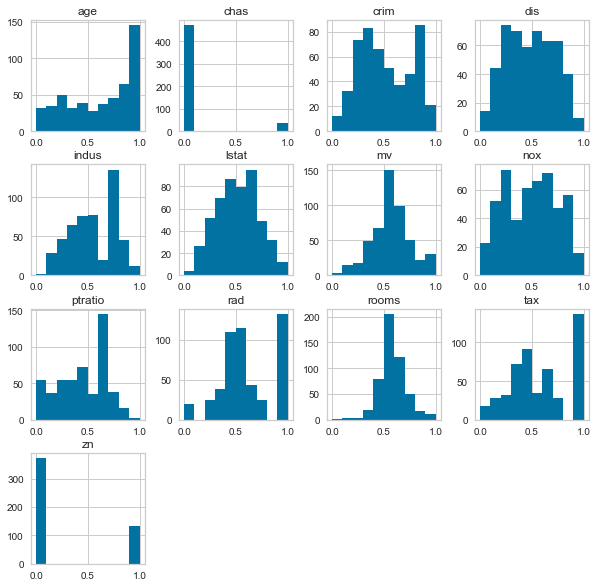

In [10]:
# Scale predictors using normalization 
boston_input_boxcox = boston_input3.transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Create pair plots of scaled data to examine attribute relationships again
boston_input_boxcox.hist(figsize=(10,10))

**Figure 12: Correlation matrix for Box Cox transformed data**

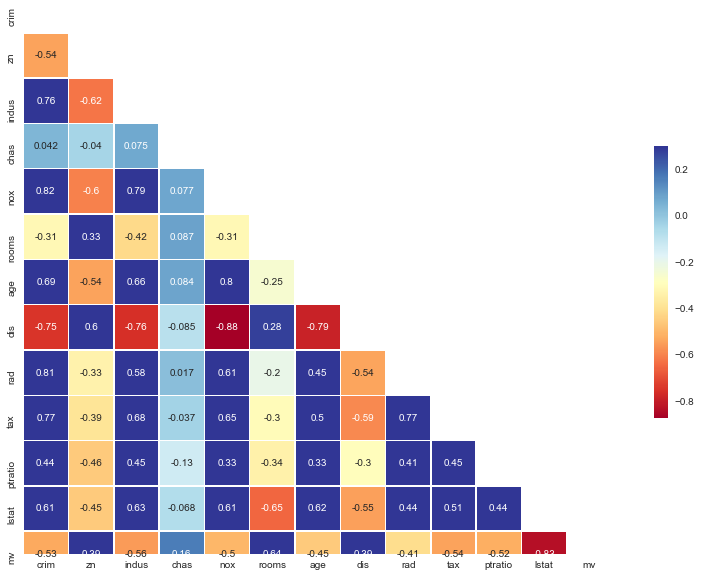

In [29]:
# Create correlation matrix for scaled data
plt.figure(figsize=(15,10))
corr = boston_input_boxcox.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, vmax=.3, cmap="RdYlBu", square=True, linewidths = .5, 
            cbar_kws={"shrink": .5})

In [11]:
# Data prep
# Prepare scaled data and inspect 
cols_scaled = boston_input_boxcox.columns.tolist()
# cols_scaled = cols_scaled[:-1] + cols_scaled[:-1]
# cols_scaled = cols_scaled[:-1] + cols_scaled[:-1]
boston_boxcox_model = boston_input_boxcox[cols_scaled]

# Inspect scaled data
boston_boxcox_model.describe(include='all')

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.518606,0.261061,0.562812,0.069170,0.490420,0.577607,0.625279,0.485270,0.625027,0.581265,0.461663,0.517794,0.566816
std,0.247164,0.435430,0.232825,0.253994,0.251621,0.129442,0.315506,0.229684,0.260145,0.280933,0.236275,0.200937,0.184926
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.319026,0.000000,0.378568,0.000000,0.249073,0.506588,0.337094,0.297601,0.491579,0.375989,0.298320,0.364902,0.469326
50%,0.476717,0.000000,0.559586,0.000000,0.500909,0.567485,0.707846,0.485207,0.562195,0.511675,0.489371,0.524193,0.567460
75%,0.771394,0.967068,0.796857,0.000000,0.678615,0.643218,0.920638,0.683853,1.000000,0.965644,0.659680,0.667866,0.644398
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model setup
Using Boxcox transformed: boston_boxcox_model<br>

In [13]:
# Seed value for random number generator to obtain reproducible results
RANDOM_SEED = 42

Original hyperparameters used

In [14]:
# Model method calls preparation
names = ['Linear_Regression', 'Ridge_Regression', 'Lasso_Regression', 'ElasticNet_Regression', 
        'RandomForest_Regression', 'ExtraTrees_Regression']

# Specify set of regression models to evaluate
# Set normal=False because data was already transformed
regressors = [LinearRegression(fit_intercept = True, normalize = False),
             Ridge(alpha=75, solver='auto', fit_intercept=True, normalize=False, 
                   random_state = RANDOM_SEED),
             Lasso(alpha=0.01, max_iter=10000, tol=0.01, fit_intercept=True, normalize=False, 
                   random_state=RANDOM_SEED),
             ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, tol=0.01, fit_intercept=True, 
                        normalize=False, random_state=RANDOM_SEED),
             RandomForestRegressor(n_estimators=10, criterion='mse', max_features=10, bootstrap=True, 
                                   n_jobs=-1, random_state=RANDOM_SEED),
             ExtraTreesRegressor(n_estimators=100, criterion='mse', max_features=10, bootstrap=True, 
                                   n_jobs=-1, random_state=RANDOM_SEED)]

Hyperparameters used for fine-tuning with grid search

In [15]:
# Model method calls preparation with adjusted hyperparameters for Random Forest and Extra Trees Regression methods
names = ['Linear_Regression', 'Ridge_Regression', 'Lasso_Regression', 'ElasticNet_Regression', 
        'RandomForest_Regression', 'ExtraTrees_Regression']

# Specify set of regression models to evaluate
# Set normal=False because data was already transformed
regressors = [LinearRegression(fit_intercept = True, normalize = False),
             Ridge(alpha=100, solver='auto', fit_intercept=True, normalize=False, 
                   random_state = RANDOM_SEED),
             Lasso(alpha=0.1, max_iter=10000, tol=0.01, fit_intercept=True, normalize=False, 
                   random_state=RANDOM_SEED),
             ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000, tol=0.01, fit_intercept=True, 
                        normalize=False, random_state=RANDOM_SEED),
             RandomForestRegressor(n_estimators=100, criterion='mse', max_features=6, bootstrap=True, 
                                   n_jobs=-1, random_state=RANDOM_SEED),
             ExtraTreesRegressor(n_estimators=100, criterion='mse', max_features=10, bootstrap=False, 
                                   n_jobs=-1, random_state=RANDOM_SEED)]

Approach 1: Model evaluation with cross-validation design
----------------------
- Log transformation of median sale price values
- Standard scaler

In [33]:
# Define model data
model_data = boston_scaled_standard_model.values

In [34]:
# Define number of cross folds to employ
N_FOLDS = 10

# Set up numpy array to store results
cv_results = np.zeros((N_FOLDS, len(names)))

# Initiate splitting process
# kf = KFold(n_splits=N_FOLDS, shuffle=False, random_state=RANDOM_SEED)
# Trying shuffle=True
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Check splitting process by looking at fold observation counts
index_for_fold = 0    # Fold count initiated
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold, '--------------------------')
    
# Data modeling structure places response variable first and predictor variables following
# 1:model_data.shape[1] slices for predictor variables and 0 is the response variable index
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]
    
    index_for_method = 0    # Initialize method cound
    for name, reg_model in zip(names, regressors):
        reg_model.fit(X_train, y_train)    # Fit on the train set for this fold
        
        # Evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
    
    index_for_fold += 1
    
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n----------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod               Root mean-squared error', sep = '')
print(cv_results_df.mean())


Fold index: 0 --------------------------

Fold index: 1 --------------------------

Fold index: 2 --------------------------

Fold index: 3 --------------------------

Fold index: 4 --------------------------

Fold index: 5 --------------------------

Fold index: 6 --------------------------

Fold index: 7 --------------------------

Fold index: 8 --------------------------

Fold index: 9 --------------------------

----------------------
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression          0.469137
Ridge_Regression           0.481631
Lasso_Regression           0.471980
ElasticNet_Regression      0.469064
RandomForest_Regression    0.381288
ExtraTrees_Regression      0.340040
dtype: float64


Approach 2: Model evaluation with cross-validation design
----------------------
- Log transformation of median sale price values
- Min-Max scaler

In [35]:
# Define model data
model_data = boston_scaled_minmax_model.values

In [36]:
# Define number of cross folds to employ
N_FOLDS = 10

# Set up numpy array to store results
cv_results = np.zeros((N_FOLDS, len(names)))

# Initiate splitting process
# kf = KFold(n_splits=N_FOLDS, shuffle=False, random_state=RANDOM_SEED)
# Trying shuffle=True
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Check splitting process by looking at fold observation counts
index_for_fold = 0    # Fold count initiated
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold, '--------------------------')
    
# Data modeling structure places response variable first and predictor variables following
# 1:model_data.shape[1] slices for predictor variables and 0 is the response variable index
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]
    
    index_for_method = 0    # Initialize method cound
    for name, reg_model in zip(names, regressors):
        reg_model.fit(X_train, y_train)    # Fit on the train set for this fold
        
        # Evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
    
    index_for_fold += 1
    
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n----------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod               Root mean-squared error', sep = '')
print(cv_results_df.mean())


Fold index: 0 --------------------------

Fold index: 1 --------------------------

Fold index: 2 --------------------------

Fold index: 3 --------------------------

Fold index: 4 --------------------------

Fold index: 5 --------------------------

Fold index: 6 --------------------------

Fold index: 7 --------------------------

Fold index: 8 --------------------------

Fold index: 9 --------------------------

----------------------
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression          0.083101
Ridge_Regression           0.126469
Lasso_Regression           0.112074
ElasticNet_Regression      0.101857
RandomForest_Regression    0.066119
ExtraTrees_Regression      0.059416
dtype: float64


Approach 3: Model evaluation with cross-validation design
----------------------
- Box Cox transformation

In [16]:
# Define model data
model_data = boston_boxcox_model.values

In [17]:
# Define number of cross folds to employ
N_FOLDS = 10

# Set up numpy array to store results
cv_results = np.zeros((N_FOLDS, len(names)))

# Initiate splitting process
# kf = KFold(n_splits=N_FOLDS, shuffle=False, random_state=RANDOM_SEED)
# Trying shuffle=True
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Check splitting process by looking at fold observation counts
index_for_fold = 0    # Fold count initiated
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold, '--------------------------')
    
# Data modeling structure places response variable first and predictor variables following
# 1:model_data.shape[1] slices for predictor variables and 0 is the response variable index
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]
    
    index_for_method = 0    # Initialize method cound
    for name, reg_model in zip(names, regressors):
        reg_model.fit(X_train, y_train)    # Fit on the train set for this fold
        
        # Evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
    
    index_for_fold += 1
    
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n----------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod               Root mean-squared error', sep = '')
print(cv_results_df.mean())


Fold index: 0 --------------------------

Fold index: 1 --------------------------

Fold index: 2 --------------------------

Fold index: 3 --------------------------

Fold index: 4 --------------------------

Fold index: 5 --------------------------

Fold index: 6 --------------------------

Fold index: 7 --------------------------

Fold index: 8 --------------------------

Fold index: 9 --------------------------

----------------------
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression          0.097324
Ridge_Regression           0.135320
Lasso_Regression           0.246740
ElasticNet_Regression      0.236236
RandomForest_Regression    0.052792
ExtraTrees_Regression      0.053582
dtype: float64


In [ ]:
# Results across all three approaches
Log transformed mv, standard scaler:
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression          0.469137
Ridge_Regression           0.481631
Lasso_Regression           0.471980
ElasticNet_Regression      0.469064
RandomForest_Regression    0.381288
ExtraTrees_Regression      0.340040

Log transformed mv, minmax scaler:
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Linear_Regression          0.083101
Ridge_Regression           0.126469
Lasso_Regression           0.112074
ElasticNet_Regression      0.101857
RandomForest_Regression    0.066119
ExtraTrees_Regression      0.059416

Box Cox scaler:
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression          0.097324
Ridge_Regression           0.135320
Lasso_Regression           0.246740
ElasticNet_Regression      0.236236
RandomForest_Regression    0.052792
ExtraTrees_Regression      0.053582

# Modeling technique comparison

Approaches 2 and 3 have relatively close RMSE values for each modeling method and are lower than approach 1's values. Random Forest and Extra Trees Regression have the best performance for this data and learning approach.

Continue using Box Cox transformed Boston housing data (model_data) for remainder of study, using alternate techniques.<br>

# Random Forest and Extra Trees Fine-Tuning

In [198]:
# Assign model data
boston_model = boston_boxcox_model

X = boston_model.drop('mv', axis=1).values
y = boston_model.mv.values

In [199]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(boston_boxcox_model, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(404, 13) (404,)
(102, 13) (102,)


## Feature importance

**Figure 13: Feature importance for Random Forest model**

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


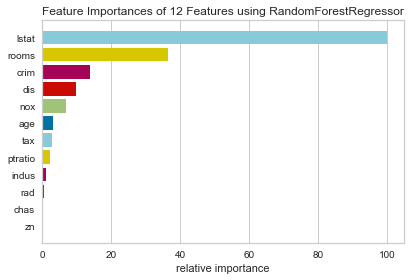

In [160]:
# Evaluate feature importance for RF

# Create feature list
feat_list = ['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat']

# Visualize with feature names
model = RandomForestRegressor(n_estimators=100)
labels = feat_list
viz = FeatureImportances(model, labels = labels)
viz.fit(X, y)
viz.show()

In [161]:
# Check numeric values of feature importance for RF
rnd_reg = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rnd_reg.fit(X, y)
for name, score in zip(feat_list, rnd_reg.feature_importances_):
    print(name, score)

crim 0.07744619796871274
zn 0.0007692577049276498
indus 0.006501757647112281
chas 0.0009219150399438937
nox 0.03841870818712361
rooms 0.21307911470146207
age 0.016838805753805017
dis 0.053357736528015835
rad 0.0027578295378056076
tax 0.016349158050766175
ptratio 0.011917910201618068
lstat 0.5616416086787069


**Figure 14: Feature importance for Extra Trees model**

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


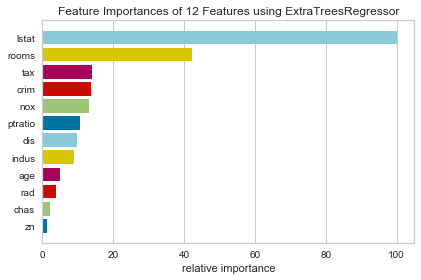

In [162]:
# Feature importance for ET

# Create feature list
feat_list = ['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat']

# Visualize with feature names
model = ExtraTreesRegressor(n_estimators=100)
labels = feat_list
viz = FeatureImportances(model, labels = labels)
viz.fit(X, y)
viz.show()

In [163]:
# Check numeric values of feature importance for ET
rnd_reg = ExtraTreesRegressor(n_estimators=500, n_jobs=-1)
rnd_reg.fit(X, y)
for name, score in zip(feat_list, rnd_reg.feature_importances_):
    print(name, score)

crim 0.06335092087768143
zn 0.00469301966393136
indus 0.0320328296368612
chas 0.008709967136886812
nox 0.056236232440205
rooms 0.19009940196937788
age 0.02157773913963331
dis 0.045450030183720805
rad 0.024667626239400983
tax 0.05043597708787062
ptratio 0.054421614319203136
lstat 0.4483246413052274


## Grid search for RF and ET

In [97]:
# Metric to use: 'neg_mean_squared_error'

# The best value is 0.0

# The actual MSE is simply the positive version of the number you're getting.

# The unified scoring API always maximizes the score, so scores which need to be minimized are 
# negated in order for the unified scoring API to work correctly. The score that is returned is 
# therefore negated when it is a score that should be minimized and left positive if it is a score 
# that should be maximized. 

# Another metric: R2
# R^2 (coefficient of determination) regression score function

# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, 
# would get a R^2 score of 0.0.

In [79]:
# RF grid search with multiple parameters - R2

# Max_features is main parameter, try # of features for regression or around that number

rf_reg = RandomForestRegressor()

param_grid = {
    'bootstrap': [True],
    'max_depth': [80,90,100,110,120],
    'max_features': [2,4,6,8,10],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [8,10,12],
    'n_estimators': [100,200,300,800,1000]
}

# grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', 
#                               return_train_score=True, n_jobs=-1, verbose=2)

grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=3, scoring='r2', 
                              return_train_score=True, n_jobs=-1, verbose=2, random_state=42)

grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 1125 candidates, totalling 3375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 3375 out of 3375 | elapsed: 17.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, rand...=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

In [80]:
# Display parameter recommendations
print('Test set score: ', grid_search_rf.score(X_test, y_test))
print('Best parameters: ', grid_search_rf.best_params_)
print('Best cross-validation score: ', grid_search_rf.best_score_)

Test set score:  -0.00037417350363380593
Best parameters:  {'bootstrap': True, 'max_depth': 100, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
Best cross-valisation score:  -0.00014726682311321917


In [ ]:
# RF grid search with multiple parameters - MSE

# Max_features is main parameter, try # of features for regression or around that number

rf_reg = RandomForestRegressor()

param_grid = {
    'bootstrap': [True],
    'max_depth': [80,90,100,110,120],
    'max_features': [2,4,6,8,10],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [8,10,12],
    'n_estimators': [100,200,300,800,1000]
}

grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', 
                              return_train_score=True, n_jobs=-1, verbose=2, random_state=42)

# grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=3, scoring='r2', 
#                               return_train_score=True, n_jobs=-1, verbose=2, random_state=42)

grid_search_rf.fit(X_train, y_train)

In [ ]:
# Display parameter recommendations
print('Test set score: ', grid_search_rf.score(X_test, y_test))
print('Best parameters: ', grid_search_rf.best_params_)
print('Best cross-validation score: ', grid_search_rf.best_score_)

In [100]:
# RF grid search with one parameter - R2

param_grid = {'max_features':range(10, 15)}

grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=3, scoring='r2', 
                              return_train_score=True, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [101]:
# Display parameter recommendations
print('Test set score: ', grid_search_rf.score(X_test, y_test))
print('Best parameters: ', grid_search_rf.best_params_)
print('Best cross-validation score: ', grid_search_rf.best_score_)

Test set score:  0.9968223271531906
Best parameters:  {'max_features': 13}
Best cross-validation score:  0.998811630568802


In [ ]:
# RF grid search with one parameter - MSE

param_grid = {'max_features':range(10, 15)}

grid_search_rf = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=3, scoring='mean_squared_error', 
                              return_train_score=True, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train, y_train)

In [ ]:
# Display parameter recommendations
print('Test set score: ', grid_search_rf.score(X_test, y_test))
print('Best parameters: ', grid_search_rf.best_params_)
print('Best cross-validation score: ', grid_search_rf.best_score_)

In [88]:
# ET grid search with multiple parameters

# Max_features is main parameter, try # of features for regression or around that number

et_reg = ExtraTreesRegressor()

param_grid = {
    'bootstrap': [True],
    'max_depth': [80,90,100,110,120],
    'max_features': [2,4,6,8,10],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [8,10,12],
    'n_estimators': [100,200,300,800,1000]
}

grid_search_et = GridSearchCV(estimator=et_reg, param_grid=param_grid, cv=3, scoring='r2', 
                              return_train_score=True, n_jobs=-1, verbose=2)

grid_search_et.fit(X_train, y_train)

Fitting 3 folds for each of 1125 candidates, totalling 3375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 3375 out of 3375 | elapsed: 14.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, rando...=None,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_gri

In [89]:
# Display parameter recommendations
print('Test set score: ', grid_search_et.score(X_test, y_test))
print('Best parameters: ', grid_search_et.best_params_)
print('Best cross-validation score: ', grid_search_et.best_score_)

Test set score:  -0.0006695978067477949
Best parameters:  {'bootstrap': True, 'max_depth': 80, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}
Best cross-valisation score:  -0.0005772259617043201


In [102]:
# ET grid search with one parameter

param_grid = {'max_features':range(10, 15)}

grid_search_et = GridSearchCV(estimator=et_reg, param_grid=param_grid, cv=3, scoring='r2', 
                              return_train_score=True, n_jobs=-1, verbose=2)

grid_search_et.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param

In [103]:
# Display parameter recommendations
print('Test set score: ', grid_search_et.score(X_test, y_test))
print('Best parameters: ', grid_search_et.best_params_)
print('Best cross-validation score: ', grid_search_et.best_score_)

Test set score:  0.9981298410615217
Best parameters:  {'max_features': 13}
Best cross-validation score:  0.9987151045356225


In [ ]:
# refit the model that does best

In [297]:
# Refit Extra Trees

# Best parameters:  {'bootstrap': True, 'max_depth': 80, 'max_features': 10, 'min_samples_leaf': 3, 
# 'min_samples_split': 8, 'n_estimators': 300}
X = boston_model.drop('mv', axis=1).values
y = boston_model.mv.values
refit_et = ExtraTreesRegressor(bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, 
                               min_samples_split=8, n_estimators=300, verbose=0, n_jobs=-1, random_state = 42)

In [298]:
refit_et.fit(X,y)

ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=80, max_features=10, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=3,
                    min_samples_split=8, min_weight_fraction_leaf=0.0,
                    n_estimators=300, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [299]:
pred = refit_et.predict(X)

In [300]:
# MSE
print("Mean squared error: %.3f"% mean_squared_error(pred, y))
print("Root MSE: %.2f"% sqrt(mean_squared_error(pred,y)))
# Explained variance score: 1 is perfect prediction
print('Test variance score: %.3f' % r2_score(pred,y))

Mean squared error: 0.003
Root MSE: 0.05
Test variance score: 0.895


**Figure 15: Actual versus predicted values with fine-tuned Extra Trees model**

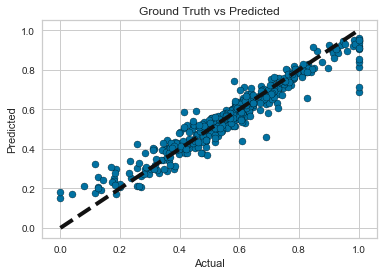

In [261]:
# Run the model against the test data
fig, ax = plt.subplots()
ax.scatter(y, pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

**Figure 16: Feature importances for fine-tuned Extra Trees model**

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


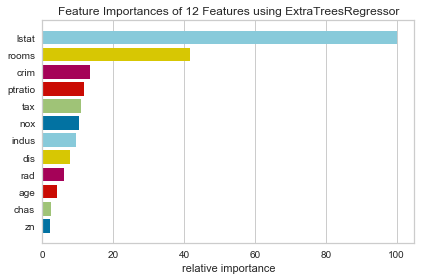

In [264]:
# Create feature list
feat_list = ['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat']

# Visualize with feature names
labels = feat_list
viz = FeatureImportances(refit_et, labels = labels)
viz.fit(X, y)
viz.show()

In [263]:
# Check numeric values of feature importance for ET
refit_et.fit(X, y)
for name, score in zip(feat_list, refit_et.feature_importances_):
    print(name, score)

crim 0.0606357682887844
zn 0.009423805168847176
indus 0.04302208971157683
chas 0.01106309553651166
nox 0.04672843888329933
rooms 0.18919655666644386
age 0.01859028495760196
dis 0.035754935547659523
rad 0.027970767541390475
tax 0.05013300766040468
ptratio 0.05359476312959453
lstat 0.45388648690788547


# Decision tree regressor

### Decision trees with single predictor feature

In [114]:
# LSTAT

# Assign X matrix and y vector
X = boston_model[['lstat']].values
# X = X.reshape(-1,1)
y = boston_model['mv'].values

# Sort X and y by ascending values of X
sort_idx = X.flatten().argsort()                  
X = X[sort_idx]
y = y[sort_idx]

# Initialize and fit regressor
tree = DecisionTreeRegressor(criterion='mse', max_depth=3)         
tree.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

**Figure 17: Actual and predicted target against feature - LSTAT**

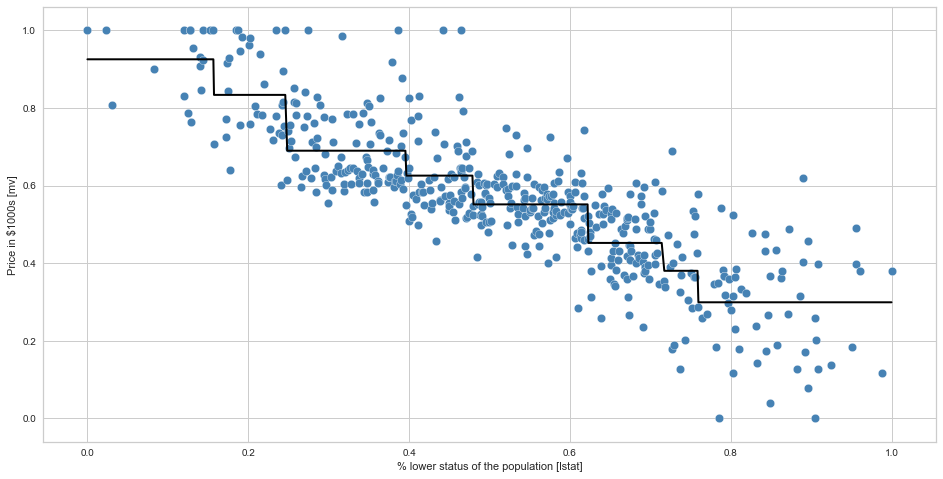

In [115]:
# Plot actual versus predicted mv values
plt.figure(figsize=(16, 8))
plt.scatter(X, y, c='steelblue',                  # Plot actual target against features
            edgecolor='white', s=70)
plt.plot(X, tree.predict(X),                      # Plot predicted target against features
         color='black', lw=2)
plt.xlabel('% lower status of the population [lstat]')
plt.ylabel('Price in $1000s [mv]')
plt.show()

In [68]:
# ROOMS

# Assign X matrix and y vector
X = boston_model[['rooms']].values
# X = X.reshape(-1,1)
y = boston_model['mv'].values

# Sort X and y by ascending values of X
sort_idx = X.flatten().argsort()                  
X = X[sort_idx]
y = y[sort_idx]

# Initialize and fit regressor
tree = DecisionTreeRegressor(criterion='mse', max_depth=3)         
tree.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

**Figure 18: Actual and predicted target against feature - ROOMS**

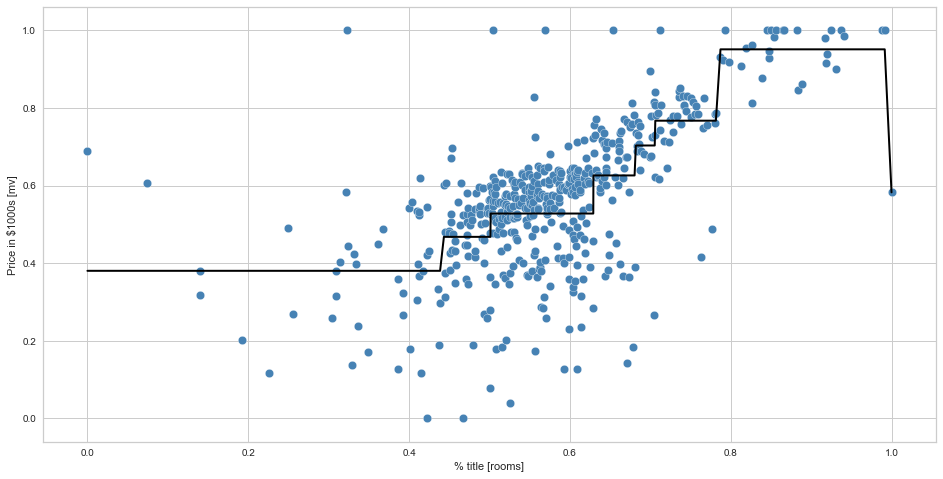

In [69]:
# Plot actual versus predicted mv values
plt.figure(figsize=(16, 8))
plt.scatter(X, y, c='steelblue',                  # Plot actual target against features
            edgecolor='white', s=70)
plt.plot(X, tree.predict(X),                      # Plot predicted target against features
         color='black', lw=2)
plt.xlabel('number of rooms [rooms]')
plt.ylabel('Price in $1000s [mv]')
plt.show()

In [70]:
# PTRATIO
# Assign X matrix and y vector
X = boston_model[['ptratio']].values
# X = X.reshape(-1,1)
y = boston_model['mv'].values

# Sort X and y by ascending values of X
sort_idx = X.flatten().argsort()                  
X = X[sort_idx]
y = y[sort_idx]

# Initialize and fit regressor
tree = DecisionTreeRegressor(criterion='mse', max_depth=3)         
tree.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

**Figure 19: Actual and predicted target against feature - PTRATIO**

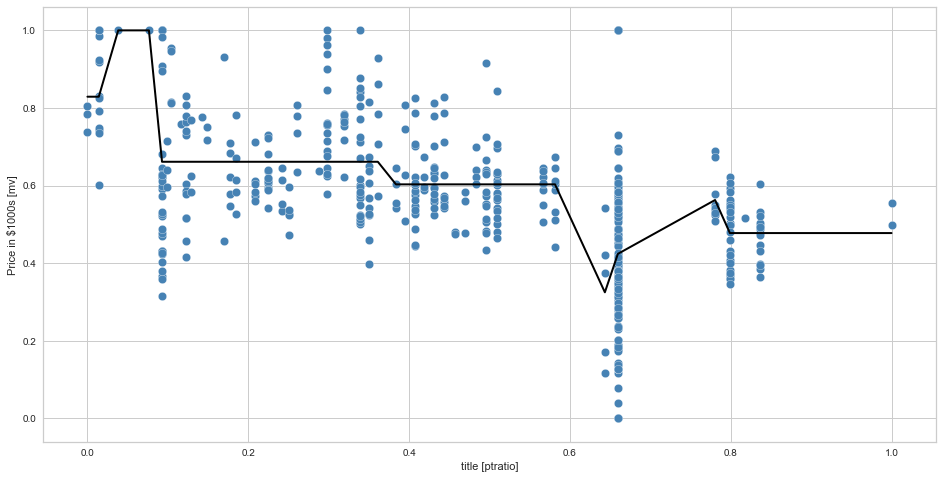

In [71]:
# Plot actual versus predicted mv values
plt.figure(figsize=(16, 8))
plt.scatter(X, y, c='steelblue',                  # Plot actual target against features
            edgecolor='white', s=70)
plt.plot(X, tree.predict(X),                      # Plot predicted target against features
         color='black', lw=2)
plt.xlabel('pupil teacher ratio by town [ptratio]')
plt.ylabel('Price in $1000s [mv]')
plt.show()

### Decision tree with multiple predictor features

In [150]:
# Split train and test set
X = boston_model.drop('mv', axis=1).values
y = boston_model.mv.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [151]:
# Define model and fit
model =  DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [153]:
# Examine R sq to give an idea of the fit
# Explained variance score: 1 is perfect prediction
model_score = model.score(X_train, y_train)
print('Coefficient of determination R^2 of the prediction.: ',model_score)

# Predict values
y_pred = model.predict(X_test)

# MSE
print("Mean squared error: %.3f"% mean_squared_error(y_test, y_pred))
print("Root MSE: %.2f"% sqrt(mean_squared_error(y_test, y_pred)))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.3f' % r2_score(y_test, y_pred))

Coefficient of determination R^2 of the prediction.:  0.9261765861164674
Mean squared error: 0.005
Root MSE: 0.07
Test Variance score: 0.827


**Figure 20: Actual versus predicted target values (mv) with Decision Tree Regressor**

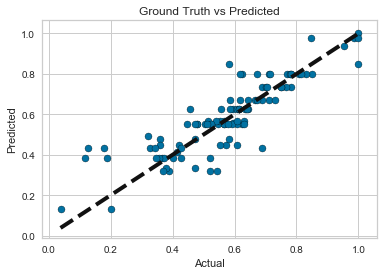

In [119]:
# Run the model against the test data
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

# Ensemble methods

There are three main terms describing the ensemble (combination) of various models into one more effective model:
- Bagging to decrease the model’s variance;
- Boosting to decreasing the model’s bias, and;
- Stacking to increasing the predictive force of the classifier.

## Gradient boosting

In [ ]:
# There's a trade-off between the learning rate and the number of trees needed, so you'll 
# have to experiment to find the best values for each of the parameters, but small values 
# less than 0.1 or values between 0.1 and 0.3 often work well.

In [313]:
# Split train and test set
X = boston_model.drop('mv', axis=1).values
y = boston_model.mv.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [314]:
# Examine R sq to give an idea of the fit
# Explained variance score: 1 is perfect prediction
model = refit_et

model_score = model.score(X_train, y_train)
print('Coefficient of determination R^2 of the prediction: ',model_score)

# Predict values
y_pred = model.predict(X_test)

# # MSE
# print("Mean squared error: %.3f"% mean_squared_error(y_test, y_pred))
# print("Root MSE: %.2f"% sqrt(mean_squared_error(y_test, y_pred)))
# # Explained variance score: 1 is perfect prediction
# print('Test variance score: %.3f' % r2_score(y_test, y_pred))

# MSE
print("Mean squared error: %.3f"% mean_squared_error(y_pred, y_test))
print("Root MSE: %.2f"% sqrt(mean_squared_error(y_pred, y_test)))
# Explained variance score: 1 is perfect prediction
print('Test variance score: %.3f' % r2_score(y_pred, y_test))

Coefficient of determination R^2 of the prediction:  0.917365565235066
Mean squared error: 0.002
Root MSE: 0.05
Test variance score: 0.906


In [315]:
# Compare performance across different learning rates
# Mainly interested in the regressor's accuracy on the test set, but it looks like a learning 
# rate of 0.3 with 12 max features gives us the best performance on the test set and good performance on the training set.
lr_list = [0.05, 0.075, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=learning_rate, max_features=10, max_depth=2, random_state=42)
    gb_reg.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_reg.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb_reg.score(X_test, y_test)))
    print('-------------------')

Learning rate:  0.05
Accuracy score (training): 0.917
Accuracy score (test): 0.850
-------------------
Learning rate:  0.075
Accuracy score (training): 0.935
Accuracy score (test): 0.862
-------------------
Learning rate:  0.1
Accuracy score (training): 0.943
Accuracy score (test): 0.870
-------------------
Learning rate:  0.2
Accuracy score (training): 0.965
Accuracy score (test): 0.878
-------------------
Learning rate:  0.3
Accuracy score (training): 0.977
Accuracy score (test): 0.872
-------------------
Learning rate:  0.5
Accuracy score (training): 0.986
Accuracy score (test): 0.857
-------------------
Learning rate:  0.75
Accuracy score (training): 0.991
Accuracy score (test): 0.868
-------------------
Learning rate:  1
Accuracy score (training): 0.994
Accuracy score (test): 0.800
-------------------


In [316]:
# Compare different  n_estimators
estimator_list = [20, 50, 100, 150, 200, 300, 400, 500]

for estimator in estimator_list:
    gb_reg = GradientBoostingRegressor(n_estimators=estimator, learning_rate=0.3, max_features=12, max_depth=2, random_state=42)
    gb_reg.fit(X_train, y_train)

    print("n_estimators: ", estimator)
    print("Accuracy score (training): {0:.3f}".format(gb_reg.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb_reg.score(X_test, y_test)))
    print('-------------------')

n_estimators:  20
Accuracy score (training): 0.920
Accuracy score (test): 0.840
-------------------
n_estimators:  50
Accuracy score (training): 0.956
Accuracy score (test): 0.841
-------------------
n_estimators:  100
Accuracy score (training): 0.977
Accuracy score (test): 0.856
-------------------
n_estimators:  150
Accuracy score (training): 0.986
Accuracy score (test): 0.852
-------------------
n_estimators:  200
Accuracy score (training): 0.991
Accuracy score (test): 0.852
-------------------
n_estimators:  300
Accuracy score (training): 0.996
Accuracy score (test): 0.846
-------------------
n_estimators:  400
Accuracy score (training): 0.998
Accuracy score (test): 0.845
-------------------
n_estimators:  500
Accuracy score (training): 0.999
Accuracy score (test): 0.845
-------------------


In [317]:
# Experiment with warm start, adds to model already built
# Starts with 1 tree, adds trees til it has enough estimators
# Each iteration adds 5 more trees; after about 60, you're basically good with # of trees
for learning_rate in lr_list:
    gb_reg_ws = RandomForestRegressor(max_depth=2, random_state=42, warm_start=True, n_estimators=100)
    gb_reg_ws.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_reg_ws.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb_reg_ws.score(X_test, y_test)))
    print('-------------------')

Learning rate:  0.05
Accuracy score (training): 0.784
Accuracy score (test): 0.759
-------------------
Learning rate:  0.075
Accuracy score (training): 0.784
Accuracy score (test): 0.759
-------------------
Learning rate:  0.1
Accuracy score (training): 0.784
Accuracy score (test): 0.759
-------------------
Learning rate:  0.2
Accuracy score (training): 0.784
Accuracy score (test): 0.759
-------------------
Learning rate:  0.3
Accuracy score (training): 0.784
Accuracy score (test): 0.759
-------------------
Learning rate:  0.5
Accuracy score (training): 0.784
Accuracy score (test): 0.759
-------------------
Learning rate:  0.75
Accuracy score (training): 0.784
Accuracy score (test): 0.759
-------------------
Learning rate:  1
Accuracy score (training): 0.784
Accuracy score (test): 0.759
-------------------


In [318]:
# Refit model with optimal learning rate and n_estimators
# Define model and fit
model =  GradientBoostingRegressor(max_depth=4, random_state=42, learning_rate=0.3, n_estimators=300, 
                                   min_samples_split=2, loss='ls')


# 'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
#           'learning_rate': 0.03, 'loss': 'ls'
                
                
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [319]:
# Examine R sq to give an idea of the fit
# Explained variance score: 1 is perfect prediction
model_score = model.score(X_train, y_train)
print('Coefficient of determination R^2 of the prediction.: ',model_score)

# Predict values
y_pred = model.predict(X_test)

# MSE
print("Mean squared error: %.3f"% mean_squared_error(y_test, y_pred))
print("Root MSE: %.3f"% sqrt(mean_squared_error(y_test, y_pred)))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.3f' % r2_score(y_test, y_pred))

Coefficient of determination R^2 of the prediction.:  0.9999971685206094
Mean squared error: 0.004
Root MSE: 0.064
Test Variance score: 0.864


**Figure 21: Actual versus predicted target values (mv) with Gradient Boosting Regressor**

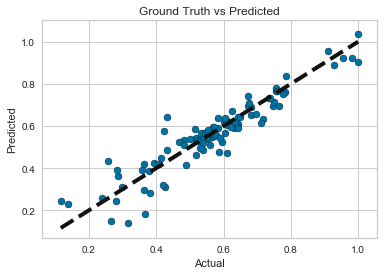

In [320]:
# Run the model against the test data
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

In [321]:
# Check numeric values of feature importance for GB
for name, score in zip(feat_list, model.feature_importances_):
    print(name, score)

crim 0.07791579331161841
zn 0.00016215554361862273
indus 0.0063858107016804486
chas 0.0011613661056134453
nox 0.04278134546163636
rooms 0.2245846309264435
age 0.013178775564784563
dis 0.0549131329169467
rad 0.006653743710461629
tax 0.014875024875555124
ptratio 0.02314527510620031
lstat 0.534242945775441


In [ ]:
# Try with SGBD
# The GradientBoostibngRegressor class also supports a subsample hyperparameter, which specifies the 
# fraction of training instances to be used for training each tree. For example, if subsample=0.25, 
# then each tree is trained on 25% of the training instances, selected randomly. This technique trades 
# a higher bias for a lower variance. It also speeds up training considerably. 
# This is called Stochastic Gradient Boosting.

In [322]:
# Try Stochastic Gradient Boosting
# Define model and fit using subsample = 0.25
model =  GradientBoostingRegressor(max_depth=4, random_state=42, learning_rate=0.3, n_estimators=500, 
                                   min_samples_split=2, loss='ls', subsample=0.25)
                          
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=0.25, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [323]:
# Examine R sq to give an idea of the fit
# Explained variance score: 1 is perfect prediction
model_score = model.score(X_train, y_train)
print('Coefficient of determination R^2 of the prediction.: ',model_score)

# Predict values
y_pred = model.predict(X_test)

# MSE
print("Mean squared error: %.3f"% mean_squared_error(y_test, y_pred))
print("Root MSE: %.3f"% sqrt(mean_squared_error(y_test, y_pred)))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.3f' % r2_score(y_test, y_pred))

Coefficient of determination R^2 of the prediction.:  0.9999419280494728
Mean squared error: 0.007
Root MSE: 0.085
Test Variance score: 0.757


**Figure 22: Actual versus predicted target values (mv) with Stochastic Gradient Boosting**

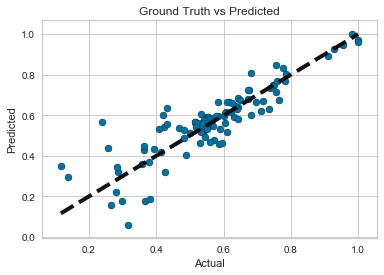

In [324]:
# Run the model against the test data
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

## Stacking

Scikit-learn stacking was implemented as follows:

- Base learners are fitted on the full X while the final estimator is trained using cross-validated predictions of the base learners using cross_val_predict.

This means that the predictions of each individual base learner are stacked together and used as input to a meta learner to compute the prediction. This meta learner is then trained through cross-validation. Cross-validation is automatically set to 5-fold CV but can be adjusted manually.

In [129]:
#  Combine 3 learners (linear and non-linear) and use a ridge regressor to combine their outputs together
estimators = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Lasso', LassoCV()),
    ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))
]
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=RidgeCV()
)

In [130]:
# Function for plotting
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

**Figure 23: Blended model results against individual models**

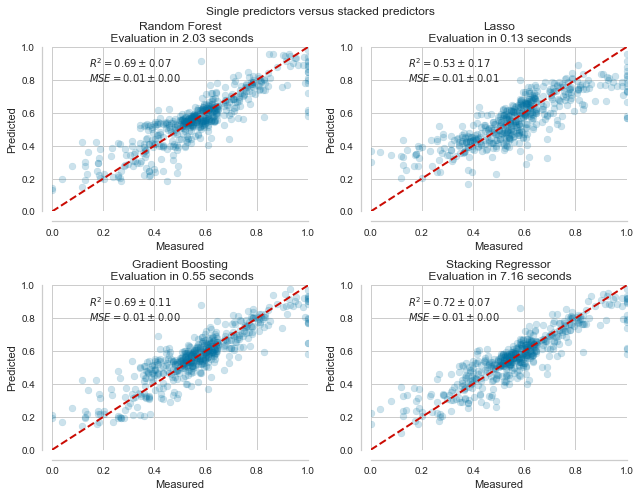

In [131]:
# Plot results
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_squared_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MSE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_squared_error']),
                np.std(score['test_neg_mean_squared_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()